# Projeto fundo de investimentos


## Contents

1. [Background](#Background)
1. [Data](#Data)
  1. [Q&A](#Q&A)
  1. [Descriptive](#Descriptive)
  1. [Engineering](#Engineering)
1. [Train](#Train)
  1. [Host](#Host)
  1. [Evaluate](#Evaluate)
1. [Tuning](#Tuning)
  
---

## Background

O projeto consiste em analisar dados de transacao de cotas e retirar insights.


**Modelos a serem desenvolvidos** 

1 - Modelo descritivo sobre perfil e evolucao das cotas por mes em cada grupo de clientes.  
2 - Modelo de pipeline de tratamento de dados e engenharia de dados, afim de criar mais informacoes  
3 - Modelo de Clusterizacao

## Metodologia

Será utilizado o modelo CRISP-DM (Cross Industry Standard Process for Data Mining). Trata-se de um modelo de processo de mineração de dados que descreve abordagens comumente usadas por especialistas em mineração de dados para a resolução de problemas e criação de modelos de aprendizado de máquina.

O CRISP-DM é constituído por 6 etapas: 
- Compreensão do Negócio
- Compreensão dos Dados
- Preparação dos Dados
- Modelagem
- Avaliação 
- Desenvolvimento

Vejamos abaixo uma figura que representa o processo CRISP-DM e como as fases se inter-relacionam:
 
 <img src="WhatsApp Image 2021-07-21 at 14.31.41.jpeg">

### Dicionário de dados 



**Dados de movimentacao**
- `#`: ID do cliente
- `data`: Data da movimentacao
- `conta`: Numero de identificacao da conta
- `operacao`: Tipo de movimentacao
- `cota`: Valor da cota
- `quantidade`: Quantidade de cota
- `financeiro`: Valor monetario da movimentacao
- `grupo`: Categorizacao do cliente 


### Importando bibliotecas necessarias 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans
import warnings
import os
warnings.filterwarnings("ignore")


### Importando dados que serao usados nas analises 

In [2]:
df10 = pd.read_excel('movimentacoes passivo (5).xlsx')

In [3]:
df10.head()

,#,data,conta,operação,cota,quantidade,financeiro,grupo
0,1,2015-03-23,419103,aplicação,1.00000,2.000000e+05,200000.0,Proprietário
1,2,2015-03-23,419107,aplicação,1.00000,1.200000e+06,1200000.0,Proprietário
2,3,2015-03-23,418451,aplicação,1.00000,5.000000e+05,500000.0,Proprietário
3,4,2015-03-23,418453,aplicação,1.00000,5.000000e+05,500000.0,Proprietário
4,5,2015-03-24,387403,aplicação,0.98822,5.059604e+04,50000.0,Pessoa Física


###  Criando DF para o power bi

In [4]:
def Scorify1(series):
    if series[0] == 'aplicação':
        return 1
    else:
        return 0

In [5]:
def Scorify2(series):
    if series[0] == 'resgate':
        return 1
    else:
        return 0

In [6]:
df10['Flag_aplicacao'] = df10[['operação']].apply(Scorify1, axis=1)

In [7]:
df10['Flag_resgate'] = df10[['operação']].apply(Scorify2, axis=1)

In [8]:
# homologacao 
df10.head()

,#,data,conta,operação,cota,quantidade,financeiro,grupo,Flag_aplicacao,Flag_resgate
0,1,2015-03-23,419103,aplicação,1.00000,2.000000e+05,200000.0,Proprietário,1,0
1,2,2015-03-23,419107,aplicação,1.00000,1.200000e+06,1200000.0,Proprietário,1,0
2,3,2015-03-23,418451,aplicação,1.00000,5.000000e+05,500000.0,Proprietário,1,0
3,4,2015-03-23,418453,aplicação,1.00000,5.000000e+05,500000.0,Proprietário,1,0
4,5,2015-03-24,387403,aplicação,0.98822,5.059604e+04,50000.0,Pessoa Física,1,0


In [9]:
df10['data'] = pd.to_datetime(df10['data'])

In [10]:
df10.dtypes

#                          int64
data              datetime64[ns]
conta                      int64
operação                  object
cota                     float64
quantidade               float64
financeiro               float64
grupo                     object
Flag_aplicacao             int64
Flag_resgate               int64
dtype: object

In [11]:
df10['Year'] = df10['data'].dt.year
df10['Month'] = df10['data'].dt.month 

In [12]:
df10['Month'] = df10['Month'].apply(str)
df10['Year']= df10['Year'].apply(str)
df10['mes_ano'] = df10['Month']+'/'+df10['Year']

In [13]:
df10.head(20)

,#,data,conta,operação,cota,quantidade,financeiro,grupo,Flag_aplicacao,Flag_resgate,Year,Month,mes_ano
0,1,2015-03-23,419103,aplicação,1.000000,2.000000e+05,200000.00,Proprietário,1,0,2015,3,3/2015
1,2,2015-03-23,419107,aplicação,1.000000,1.200000e+06,1200000.00,Proprietário,1,0,2015,3,3/2015
2,3,2015-03-23,418451,aplicação,1.000000,5.000000e+05,500000.00,Proprietário,1,0,2015,3,3/2015
3,4,2015-03-23,418453,aplicação,1.000000,5.000000e+05,500000.00,Proprietário,1,0,2015,3,3/2015
4,5,2015-03-24,387403,aplicação,0.988220,5.059604e+04,50000.00,Pessoa Física,1,0,2015,3,3/2015
5,6,2015-03-25,110277,aplicação,0.990137,1.009961e+05,100000.00,Pessoa Física,1,0,2015,3,3/2015
6,7,2015-03-27,420451,aplicação,0.977224,1.023307e+04,10000.00,Pessoa Física,1,0,2015,3,3/2015
7,8,2015-03-30,417869,aplicação,0.991796,1.748143e+05,173380.13,Proprietário,1,0,2015,3,3/2015
8,9,2015-03-30,417691,aplicação,0.991796,1.854345e+05,183913.20,Pessoa Física,1,0,2015,3,3/2015
9,10,2015-03-30,417687,aplicação,0.991796,2.066958e+05,205000.00,Proprietário,1,0,2015,3,3/2015


In [14]:
df10.to_csv('dados_powerbi.csv')

###  Criando DF para clusterizacao 

In [15]:
df10.groupby(['conta']).sum()

,#,cota,quantidade,financeiro,Flag_aplicacao,Flag_resgate
conta,,,,,,
15825,718,7.631899,28108.814315,70000.00,3,0
94135,10321,4.900427,40812.774150,200000.00,1,0
110277,39,1.990429,-0.004200,-1025.61,1,1
247291,947,11.030086,-0.002390,-375470.55,4,4
247303,186,2.439651,-0.002000,-737809.20,1,1
...,...,...,...,...,...,...
120752715,16076,4.746005,2064.894754,9800.00,1,0
120755489,16104,4.746005,6953.217028,33000.00,1,0
120756527,16094,4.746005,421.407093,2000.00,1,0


In [16]:
df_saldo = df10.groupby(['conta'])['quantidade'].sum()

In [17]:
df_saldo = pd.DataFrame(df_saldo)

In [18]:
df11 = df10.groupby(['conta'])['quantidade'].sum()

In [19]:
df11.reset_index()

,conta,quantidade
0,15825,28108.814315
1,94135,40812.774150
2,110277,-0.004200
3,247291,-0.002390
4,247303,-0.002000
...,...,...
7056,120752715,2064.894754
7057,120755489,6953.217028
7058,120756527,421.407093
7059,120756529,7796.031213


In [20]:
df_saldo.head()

,quantidade
conta,
15825,28108.814315
94135,40812.774150
110277,-0.004200
247291,-0.002390
247303,-0.002000


In [21]:
#regra para identificar os erros de base (saldo que nao é zerado, isto é, menores que 1)
def ERRO_BASE_SALDO(series):
    if series[0] < 1 :
        return 1
    else:
        return 0

In [22]:
df_saldo['Flag_ERRO_BASE_SALDO'] = df_saldo[['quantidade']].apply(ERRO_BASE_SALDO, axis=1)

In [23]:
df_saldo.head(10)

,quantidade,Flag_ERRO_BASE_SALDO
conta,,
15825,28108.814315,0
94135,40812.774150,0
110277,-0.004200,1
247291,-0.002390,1
247303,-0.002000,1
247741,-0.002550,1
254603,20613.462840,0
355803,-0.000300,1
387403,0.005350,1


In [24]:
df_saldo.count()

quantidade              7061
Flag_ERRO_BASE_SALDO    7061
dtype: int64

In [25]:
indexNames = df_saldo[(df_saldo['Flag_ERRO_BASE_SALDO'] == 1)].index
df_saldo.drop(indexNames , inplace=True)

In [26]:
df_saldo.head(10)

,quantidade,Flag_ERRO_BASE_SALDO
conta,,
15825,2.810881e+04,0
94135,4.081277e+04,0
254603,2.061346e+04,0
417687,4.229803e+05,0
417869,1.228839e+06,0
418451,1.739721e+06,0
419103,8.789309e+04,0
419107,1.526938e+06,0
420451,5.447053e+03,0


In [27]:
df_saldo['quantidade'] = df_saldo['quantidade'].astype(float)

In [28]:
df_saldo.head(10)

,quantidade,Flag_ERRO_BASE_SALDO
conta,,
15825,2.810881e+04,0
94135,4.081277e+04,0
254603,2.061346e+04,0
417687,4.229803e+05,0
417869,1.228839e+06,0
418451,1.739721e+06,0
419103,8.789309e+04,0
419107,1.526938e+06,0
420451,5.447053e+03,0


In [29]:
df_saldo.count()

quantidade              5632
Flag_ERRO_BASE_SALDO    5632
dtype: int64

In [30]:
df_saldo = df_saldo.reset_index()

In [31]:
df_saldo =  df_saldo[['conta','quantidade']]

In [32]:
df_saldo

,conta,quantidade
0,15825,2.810881e+04
1,94135,4.081277e+04
2,254603,2.061346e+04
3,417687,4.229803e+05
4,417869,1.228839e+06
...,...,...
5627,120752715,2.064895e+03
5628,120755489,6.953217e+03
5629,120756527,4.214071e+02
5630,120756529,7.796031e+03


In [33]:
df_saldo.columns = ['conta','saldo_conta']

In [34]:
df_saldo

,conta,saldo_conta
0,15825,2.810881e+04
1,94135,4.081277e+04
2,254603,2.061346e+04
3,417687,4.229803e+05
4,417869,1.228839e+06
...,...,...
5627,120752715,2.064895e+03
5628,120755489,6.953217e+03
5629,120756527,4.214071e+02
5630,120756529,7.796031e+03


# fim da tabela de saldo, vou usar ela agora só no final

In [35]:
df_cluster = df10

In [36]:
df_cluster.count()

#                 16106
data              16106
conta             16106
operação          16106
cota              16106
quantidade        16106
financeiro        16106
grupo             16095
Flag_aplicacao    16106
Flag_resgate      16106
Year              16106
Month             16106
mes_ano           16106
dtype: int64

In [37]:
df_cluster_quantidade = df_cluster.groupby(['conta', 'operação'])['quantidade'].sum()

In [38]:
df_cluster_quantidade = pd.DataFrame(df_cluster_quantidade)

In [39]:
df_cluster_quantidade = df_cluster_quantidade.sort_values(by=['conta'])

In [40]:
df_cluster_quantidade.head(20)

quantidade
conta  operação               
15825  aplicação  2.810881e+04
94135  aplicação  4.081277e+04
110277 aplicação  1.009961e+05
       resgate   -1.009961e+05
247291 aplicação  9.980463e+05
       resgate   -9.980463e+05
247303 aplicação  1.737055e+06
       resgate   -1.737055e+06
247741 aplicação  7.523638e+04
       resgate   -7.523638e+04
254603 aplicação  2.061346e+04
355803 aplicação  3.319939e+06
       resgate   -3.319939e+06
387403 aplicação  5.059604e+04
       resgate   -5.059603e+04
415661 resgate   -1.540032e+06
       aplicação  1.540032e+06
417687 aplicação  5.700693e+05
       resgate   -1.470891e+05
417691 aplicação  1.854345e+05

In [41]:
#regra para identificar os erros de base (saldo que nao é zerado, isto é, menores que 1)
def RESGATE(series):
    if series[0] < 0 :
        return series[0]
    else:
        return 0

In [42]:
#regra para identificar os erros de base (saldo que nao é zerado, isto é, menores que 1)
def APLICACAO(series):
    if series[0] > 0 :
        return series[0]
    else:
        return 0

In [43]:
df_cluster_quantidade['APLICACAO'] = df_cluster_quantidade[['quantidade']].apply(APLICACAO, axis=1)

In [44]:
df_cluster_quantidade['RESGATE'] = df_cluster_quantidade[['quantidade']].apply(RESGATE, axis=1)

In [45]:
df_cluster_quantidade.head(20)

quantidade     APLICACAO       RESGATE
conta  operação                                           
15825  aplicação  2.810881e+04  2.810881e+04  0.000000e+00
94135  aplicação  4.081277e+04  4.081277e+04  0.000000e+00
110277 aplicação  1.009961e+05  1.009961e+05  0.000000e+00
       resgate   -1.009961e+05  0.000000e+00 -1.009961e+05
247291 aplicação  9.980463e+05  9.980463e+05  0.000000e+00
       resgate   -9.980463e+05  0.000000e+00 -9.980463e+05
247303 aplicação  1.737055e+06  1.737055e+06  0.000000e+00
       resgate   -1.737055e+06  0.000000e+00 -1.737055e+06
247741 aplicação  7.523638e+04  7.523638e+04  0.000000e+00
       resgate   -7.523638e+04  0.000000e+00 -7.523638e+04
254603 aplicação  2.061346e+04  2.061346e+04  0.000000e+00
355803 aplicação  3.319939e+06  3.319939e+06  0.000000e+00
       resgate   -3.319939e+06  0.000000e+00 -3.319939e+06
387403 aplicação  5.059604e+04  5.059604e+04  0.000000e+00
       resgate   -5.059603e+04  0.000000e+00 -5.059603e+04
415661 resgate   -1.540032e+06  0.000000e+00 -1.540032e+06
       aplicação  1.540032e+06  1.540032e+06  0.000000e+00
417687 aplicação  5.700693e+05  5.700693e+05  0.000000e+00
       resgate   -1.470891e+05  0.000000e+00 -1.470891e+05
417691 aplicação  1.854345e+05  1.854345e+05  0.000000e+00

In [46]:
df_cluster_quantidade_APLICACAO = df_cluster_quantidade.groupby(['conta'])['APLICACAO'].sum()
df_cluster_quantidade_APLICACAO = pd.DataFrame(df_cluster_quantidade_APLICACAO)
df_cluster_quantidade_APLICACAO = df_cluster_quantidade_APLICACAO.sort_values(by=['conta'])
df_cluster_quantidade_APLICACAO.head(20)

,APLICACAO
conta,
15825,2.810881e+04
94135,4.081277e+04
110277,1.009961e+05
247291,9.980463e+05
247303,1.737055e+06
247741,7.523638e+04
254603,2.061346e+04
355803,3.319939e+06
387403,5.059604e+04


In [47]:
df_cluster_quantidade_RESGATE = df_cluster_quantidade.groupby(['conta'])['RESGATE'].sum()
df_cluster_quantidade_RESGATE = pd.DataFrame(df_cluster_quantidade_RESGATE)
df_cluster_quantidade_RESGATE = df_cluster_quantidade_RESGATE.sort_values(by=['conta'])
df_cluster_quantidade_RESGATE.head(20)

,RESGATE
conta,
15825,0.000000e+00
94135,0.000000e+00
110277,-1.009961e+05
247291,-9.980463e+05
247303,-1.737055e+06
247741,-7.523638e+04
254603,0.000000e+00
355803,-3.319939e+06
387403,-5.059603e+04


### Quantidade de aplicacoes

In [48]:
df_cluster_aplicacao = df_cluster.groupby(['conta', 'operação'])['Flag_aplicacao'].sum()
df_cluster_aplicacao = pd.DataFrame(df_cluster_aplicacao)
df_cluster_aplicacao = df_cluster_aplicacao.sort_values(by=['conta'])
df_cluster_aplicacao = df_cluster.groupby(['conta'])['Flag_aplicacao'].sum()
df_cluster_aplicacao = pd.DataFrame(df_cluster_aplicacao)
df_cluster_aplicacao = df_cluster_aplicacao.sort_values(by=['conta'])
df_cluster_aplicacao.head(20)

,Flag_aplicacao
conta,
15825,3
94135,1
110277,1
247291,4
247303,1
247741,1
254603,1
355803,3
387403,1


### Quantidade de resgates

In [49]:
df_cluster_resgate = df_cluster.groupby(['conta', 'operação'])['Flag_resgate'].sum()
df_cluster_resgate = pd.DataFrame(df_cluster_resgate)
df_cluster_resgate = df_cluster_resgate.sort_values(by=['conta'])
df_cluster_resgate = df_cluster.groupby(['conta'])['Flag_resgate'].sum()
df_cluster_resgate = pd.DataFrame(df_cluster_resgate)
df_cluster_resgate = df_cluster_resgate.sort_values(by=['conta'])
df_cluster_resgate.head(20)

,Flag_resgate
conta,
15825,0
94135,0
110277,1
247291,4
247303,1
247741,1
254603,0
355803,6
387403,1


In [50]:
df_cluster_quantidade_APLICACAO.columns = [ 'qtd_cotas_aplicadas_sum']
df_cluster_quantidade_RESGATE.columns = ['qtd_cotas_resgatadas_sum']
df_cluster_aplicacao.columns = ['qtd_aplicacoes']
df_cluster_resgate.columns = ['qtd_resgates']

In [51]:
df_cluster_quantidade_APLICACAO = df_cluster_quantidade_APLICACAO.reset_index()
df_cluster_quantidade_RESGATE= df_cluster_quantidade_RESGATE.reset_index()
df_cluster_aplicacao = df_cluster_aplicacao.reset_index()
df_cluster_resgate = df_cluster_resgate.reset_index()

In [52]:
df_conta = df_cluster_resgate['conta']
df_conta = df_conta.reset_index()
df_conta = pd.DataFrame(df_conta)

In [53]:
print(df_conta)

      index      conta
0         0      15825
1         1      94135
2         2     110277
3         3     247291
4         4     247303
...     ...        ...
7056   7056  120752715
7057   7057  120755489
7058   7058  120756527
7059   7059  120756529
7060   7060  120756531

[7061 rows x 2 columns]


In [54]:
df_clusterizacao1 = df_conta.merge(df_cluster_quantidade_APLICACAO, how='left', on='conta')
df_clusterizacao2 = df_clusterizacao1.merge(df_cluster_quantidade_RESGATE, how='left', on='conta')
df_clusterizacao3 = df_clusterizacao2.merge(df_cluster_aplicacao, how='left', on='conta')
df_clusterizacao4 = df_clusterizacao3.merge(df_cluster_resgate, how='left', on='conta')
df_clusterizacao4


,index,conta,qtd_cotas_aplicadas_sum,qtd_cotas_resgatadas_sum,qtd_aplicacoes,qtd_resgates
0,0,15825,2.810881e+04,0.000000e+00,3,0
1,1,94135,4.081277e+04,0.000000e+00,1,0
2,2,110277,1.009961e+05,-1.009961e+05,1,1
3,3,247291,9.980463e+05,-9.980463e+05,4,4
4,4,247303,1.737055e+06,-1.737055e+06,1,1
...,...,...,...,...,...,...
7056,7056,120752715,2.064895e+03,0.000000e+00,1,0
7057,7057,120755489,6.953217e+03,0.000000e+00,1,0
7058,7058,120756527,4.214071e+02,0.000000e+00,1,0
7059,7059,120756529,7.796031e+03,0.000000e+00,1,0


In [55]:
df_clusterizacao4['ticket_medio_cotas_aplicacao'] = df_clusterizacao4['qtd_cotas_aplicadas_sum']/df_clusterizacao4['qtd_aplicacoes']
df_clusterizacao4['ticket_medio_cotas_resgate'] = df_clusterizacao4['qtd_cotas_resgatadas_sum']/df_clusterizacao4['qtd_resgates']
df_clusterizacao4 = df_clusterizacao4.fillna(0)
df_clusterizacao4 = df_clusterizacao4[['conta','qtd_aplicacoes','qtd_resgates','ticket_medio_cotas_aplicacao','ticket_medio_cotas_resgate']]
df_clusterizacao4

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate
0,15825,3,0,9.369605e+03,0.000000e+00
1,94135,1,0,4.081277e+04,0.000000e+00
2,110277,1,1,1.009961e+05,-1.009961e+05
3,247291,4,4,2.495116e+05,-2.495116e+05
4,247303,1,1,1.737055e+06,-1.737055e+06
...,...,...,...,...,...
7056,120752715,1,0,2.064895e+03,0.000000e+00
7057,120755489,1,0,6.953217e+03,0.000000e+00
7058,120756527,1,0,4.214071e+02,0.000000e+00
7059,120756529,1,0,7.796031e+03,0.000000e+00


In [56]:
df_clusterizacao5 = df_clusterizacao4.merge(df_saldo, how='left', on='conta')
df_clusterizacao5 = df_clusterizacao5.fillna(0)
df_clusterizacao5

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta
0,15825,3,0,9.369605e+03,0.000000e+00,28108.814315
1,94135,1,0,4.081277e+04,0.000000e+00,40812.774150
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000
...,...,...,...,...,...,...
7056,120752715,1,0,2.064895e+03,0.000000e+00,2064.894754
7057,120755489,1,0,6.953217e+03,0.000000e+00,6953.217028
7058,120756527,1,0,4.214071e+02,0.000000e+00,421.407093
7059,120756529,1,0,7.796031e+03,0.000000e+00,7796.031213


In [57]:
#regra para identificar os erros de base (saldo que nao é zerado, isto é, menores que 1)
def ATIVO_INATIVO(series):
    if series[0] == 0 :
        return 0
    else:
        return 1

In [58]:
df_clusterizacao5['ATIVO_INATIVO'] = df_clusterizacao5[['saldo_conta']].apply(ATIVO_INATIVO, axis=1)

In [59]:
df_clusterizacao5.head()

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO
0,15825,3,0,9.369605e+03,0.000000e+00,28108.814315,1
1,94135,1,0,4.081277e+04,0.000000e+00,40812.774150,1
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000,0


In [60]:
##df_clusterizacao5.to_csv('CLUSTER.csv')

## Cluster 01 com todas as variaveis

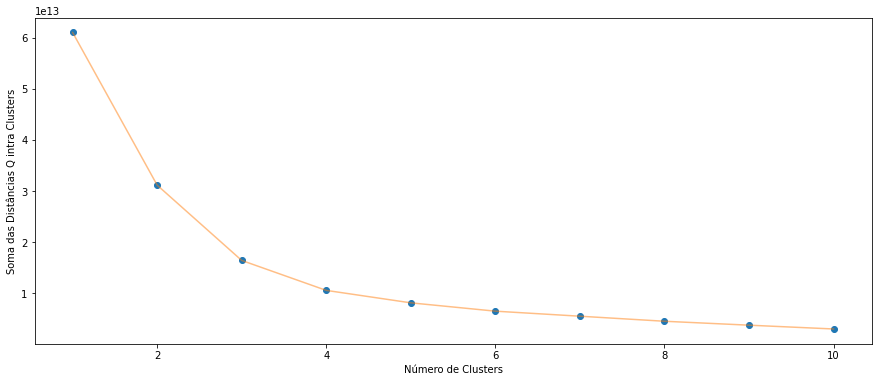

In [61]:
# Selecionando o número de clusters através do método Elbow (Soma das distâncias quadráticas intra clusters):
X2 = df_clusterizacao5[['qtd_aplicacoes', 'qtd_resgates' ,'ticket_medio_cotas_aplicacao', 'ticket_medio_cotas_resgate', 'saldo_conta' ]].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)
    
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

Conforme o número de clusters aumenta a soma das distâncias quadráticas intra clusters diminui, quando a diferença entre a distância é quase insignificante temos o valor ótimo de k , no nosso exemplo esse valor seria igual a 3.

In [62]:
# Inicializando e Computando o KMeans com o valor de 3 clusters:
algorithm = (KMeans(n_clusters = 3))
algorithm.fit(X2)

# Saída:

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(n_clusters=4, n_jobs=None, precompute_distances='auto')

In [63]:
df_clusterizacao5["cluster1"] = algorithm.labels_
df_clusterizacao5.head(50)

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000e+00,0,0
6,254603,1,0,2.061346e+04,0.000000e+00,2.061346e+04,1,0
7,355803,3,6,1.106646e+06,-5.533231e+05,0.000000e+00,0,2
8,387403,1,1,5.059604e+04,-5.059603e+04,0.000000e+00,0,0
9,415661,1,1,1.540032e+06,-1.540032e+06,0.000000e+00,0,2


In [64]:
df_group = df_clusterizacao5.groupby("cluster1")
df_group.head()

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000e+00,0,0
7,355803,3,6,1.106646e+06,-5.533231e+05,0.000000e+00,0,2
9,415661,1,1,1.540032e+06,-1.540032e+06,0.000000e+00,0,2
13,417869,6,0,2.048065e+05,0.000000e+00,1.228839e+06,1,1
14,418451,8,5,3.919526e+05,-2.791800e+05,1.739721e+06,1,1


In [65]:
df_group.describe()

conta                                                    \
           count          mean           std       min         25%   
cluster1                                                             
0         7039.0  6.311503e+07  5.372443e+07   15825.0  12955706.0   
1           17.0  5.150405e+06  4.209934e+06  417869.0    872527.0   
2            5.0  2.483241e+06  4.031779e+06  247303.0    355803.0   

                                               qtd_aplicacoes            ...  \
                 50%          75%          max          count      mean  ...   
cluster1                                                                 ...   
0         13164621.0  120149250.0  120756531.0         7039.0  1.788890  ...   
1          4730839.0    8859999.0   13105147.0           17.0  8.411765  ...   
2           415661.0    1790903.0    9606537.0            5.0  2.400000  ...   

           saldo_conta               ATIVO_INATIVO                           \
                   75%           max         count      mean       std  min   
cluster1                                                                      
0         4.928889e+03  5.883805e+05        7039.0  0.797699  0.401744  0.0   
1         1.526938e+06  2.279817e+06          17.0  1.000000  0.000000  1.0   
2         0.000000e+00  0.000000e+00           5.0  0.000000  0.000000  0.0   

                              
          25%  50%  75%  max  
cluster1                      
0         1.0  1.0  1.0  1.0  
1         1.0  1.0  1.0  1.0  
2         0.0  0.0  0.0  0.0  

[3 rows x 56 columns]

## Cluster 02 com variaveis (qtd_aplicacoes e ticket_medio_cotas_resgate)

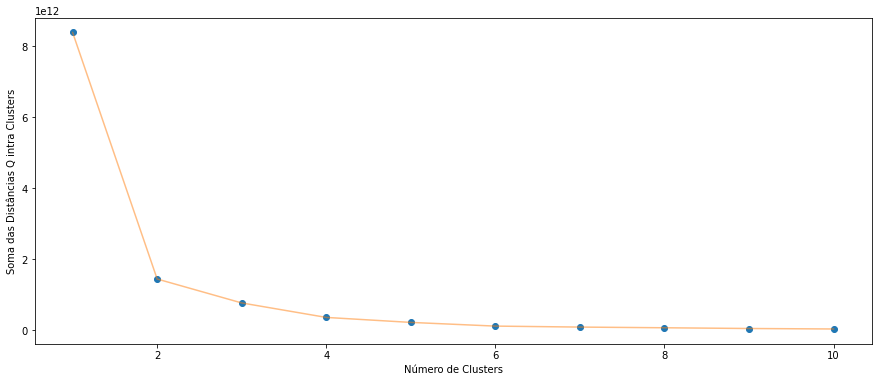

In [66]:
# Selecionando o número de clusters através do método Elbow (Soma das distâncias quadráticas intra clusters):
X3 = df_clusterizacao5[['qtd_aplicacoes' ,'ticket_medio_cotas_resgate' ]].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)
    
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

Conforme o número de clusters aumenta a soma das distâncias quadráticas intra clusters diminui, quando a diferença entre a distância é quase insignificante temos o valor ótimo de k , no nosso exemplo esse valor seria igual a 2.

In [67]:
# Inicializando e Computando o KMeans com o valor de 3 clusters:
algorithm = (KMeans(n_clusters = 2))
algorithm.fit(X3)

# Saída:

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(n_clusters=4, n_jobs=None, precompute_distances='auto')

In [68]:
df_clusterizacao5["cluster2"] = algorithm.labels_
df_clusterizacao5.head(50)

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1,cluster2
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0,0
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0,0
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2,1
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000e+00,0,0,0
6,254603,1,0,2.061346e+04,0.000000e+00,2.061346e+04,1,0,0
7,355803,3,6,1.106646e+06,-5.533231e+05,0.000000e+00,0,2,0
8,387403,1,1,5.059604e+04,-5.059603e+04,0.000000e+00,0,0,0
9,415661,1,1,1.540032e+06,-1.540032e+06,0.000000e+00,0,2,1


In [69]:
df_group = df_clusterizacao5.groupby("cluster2")
df_group.head()

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1,cluster2
0,15825,3,0,9.369605e+03,0.000000e+00,28108.814315,1,0,0
1,94135,1,0,4.081277e+04,0.000000e+00,40812.774150,1,0,0
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000,0,0,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000,0,0,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000,0,2,1
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000,0,0,0
9,415661,1,1,1.540032e+06,-1.540032e+06,0.000000,0,2,1
75,1790903,1,1,1.071234e+06,-1.071234e+06,0.000000,0,2,1
145,9606537,6,9,1.393303e+06,-9.288689e+05,0.000000,0,2,1


In [70]:
df_group.describe()

conta                                                    \
           count          mean           std       min         25%   
cluster2                                                             
0         7057.0  6.296650e+07  5.373660e+07   15825.0  12954507.0   
1            4.0  3.015101e+06  4.448351e+06  247303.0    373571.5   

                                               qtd_aplicacoes            ...  \
                 50%          75%          max          count      mean  ...   
cluster2                                                                 ...   
0         13164473.0  120145067.0  120756531.0         7057.0  1.805016  ...   
1          1103282.0    3744811.5    9606537.0            4.0  2.250000  ...   

         ATIVO_INATIVO      cluster1                                          \
                   75%  max    count      mean       std  min  25%  50%  75%   
cluster2                                                                       
0                  1.0  1.0   7057.0  0.002692  0.054488  0.0  0.0  0.0  0.0   
1                  0.0  0.0      4.0  2.000000  0.000000  2.0  2.0  2.0  2.0   

               
          max  
cluster2       
0         2.0  
1         2.0  

[2 rows x 64 columns]

## Cluster 03 com variaveis (qtd_resgates e ticket_medio_cotas_aplicacao)

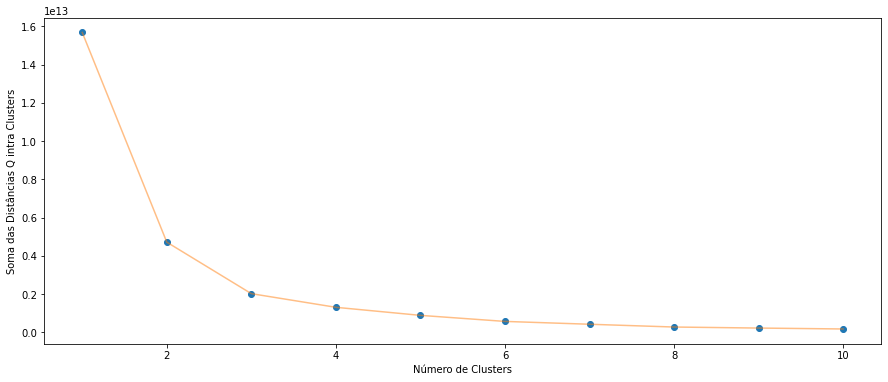

In [71]:
# Selecionando o número de clusters através do método Elbow (Soma das distâncias quadráticas intra clusters):
X4 = df_clusterizacao5[['qtd_resgates', 'ticket_medio_cotas_aplicacao']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(X4)
    inertia.append(algorithm.inertia_)
    
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

Conforme o número de clusters aumenta a soma das distâncias quadráticas intra clusters diminui, quando a diferença entre a distância é quase insignificante temos o valor ótimo de k , no nosso exemplo esse valor seria igual a 2.

In [72]:
# Inicializando e Computando o KMeans com o valor de 3 clusters:
algorithm = (KMeans(n_clusters = 2))
algorithm.fit(X4)

# Saída:

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(n_clusters=4, n_jobs=None, precompute_distances='auto')

In [73]:
df_clusterizacao5["cluster3"] = algorithm.labels_
df_clusterizacao5.head(50)

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1,cluster2,cluster3
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0,0,0
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0,0,0
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0,0,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0,0,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2,1,1
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000e+00,0,0,0,0
6,254603,1,0,2.061346e+04,0.000000e+00,2.061346e+04,1,0,0,0
7,355803,3,6,1.106646e+06,-5.533231e+05,0.000000e+00,0,2,0,1
8,387403,1,1,5.059604e+04,-5.059603e+04,0.000000e+00,0,0,0,0
9,415661,1,1,1.540032e+06,-1.540032e+06,0.000000e+00,0,2,1,1


In [74]:
df_group = df_clusterizacao5.groupby("cluster3")
df_group.head()

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1,cluster2,cluster3
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0,0,0
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0,0,0
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0,0,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0,0,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2,1,1
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000e+00,0,0,0,0
7,355803,3,6,1.106646e+06,-5.533231e+05,0.000000e+00,0,2,0,1
9,415661,1,1,1.540032e+06,-1.540032e+06,0.000000e+00,0,2,1,1
17,419107,2,0,7.634688e+05,0.000000e+00,1.526938e+06,1,1,0,1
40,872527,3,0,6.013791e+05,0.000000e+00,1.804137e+06,1,1,0,1


In [75]:
df_group.describe()

conta                                                    \
           count          mean           std       min         25%   
cluster3                                                             
0         7052.0  6.300962e+07  5.373120e+07   15825.0  12954598.0   
1            9.0  2.536348e+06  3.353973e+06  247303.0    415661.0   

                                               qtd_aplicacoes            ...  \
                 50%          75%          max          count      mean  ...   
cluster3                                                                 ...   
0         13164490.0  120145141.5  120756531.0         7052.0  1.804736  ...   
1           872527.0    2377961.0    9606537.0            9.0  2.222222  ...   

         cluster1      cluster2                                               
              75%  max    count      mean       std  min  25%  50%  75%  max  
cluster3                                                                      
0             0.0  1.0   7052.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
1             2.0  2.0      9.0  0.444444  0.527046  0.0  0.0  0.0  1.0  1.0  

[2 rows x 72 columns]

## Cluster 04 com variaveis (ticket_medio_cotas_aplicacao e saldo_conta)

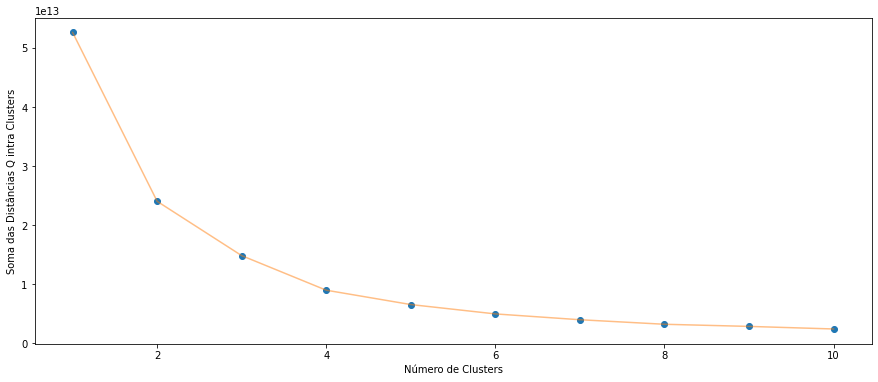

In [76]:
# Selecionando o número de clusters através do método Elbow (Soma das distâncias quadráticas intra clusters):
X5 = df_clusterizacao5[['ticket_medio_cotas_aplicacao' , 'saldo_conta']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(X5)
    inertia.append(algorithm.inertia_)
    
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

Conforme o número de clusters aumenta a soma das distâncias quadráticas intra clusters diminui, quando a diferença entre a distância é quase insignificante temos o valor ótimo de k , no nosso exemplo esse valor seria igual a 2.

In [77]:
# Inicializando e Computando o KMeans com o valor de 3 clusters:
algorithm = (KMeans(n_clusters = 2))
algorithm.fit(X5)

# Saída:

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(n_clusters=4, n_jobs=None, precompute_distances='auto')

In [78]:
df_clusterizacao5["cluster4"] = algorithm.labels_
df_clusterizacao5.head(50)

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1,cluster2,cluster3,cluster4
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0,0,0,0
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0,0,0,0
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0,0,0,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0,0,0,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2,1,1,1
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000e+00,0,0,0,0,0
6,254603,1,0,2.061346e+04,0.000000e+00,2.061346e+04,1,0,0,0,0
7,355803,3,6,1.106646e+06,-5.533231e+05,0.000000e+00,0,2,0,1,1
8,387403,1,1,5.059604e+04,-5.059603e+04,0.000000e+00,0,0,0,0,0
9,415661,1,1,1.540032e+06,-1.540032e+06,0.000000e+00,0,2,1,1,1


In [79]:
df_group = df_clusterizacao5.groupby("cluster4")
df_group.head()

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1,cluster2,cluster3,cluster4
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0,0,0,0
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0,0,0,0
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0,0,0,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0,0,0,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2,1,1,1
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000e+00,0,0,0,0,0
7,355803,3,6,1.106646e+06,-5.533231e+05,0.000000e+00,0,2,0,1,1
9,415661,1,1,1.540032e+06,-1.540032e+06,0.000000e+00,0,2,1,1,1
13,417869,6,0,2.048065e+05,0.000000e+00,1.228839e+06,1,1,0,0,1
14,418451,8,5,3.919526e+05,-2.791800e+05,1.739721e+06,1,1,0,0,1


In [80]:
df_group.describe()

conta                                                    \
           count          mean           std       min         25%   
cluster4                                                             
0         7030.0  6.315427e+07  5.372123e+07   15825.0  12955713.5   
1           31.0  1.264941e+07  2.902836e+07  247303.0   1331715.0   

                                               qtd_aplicacoes            ...  \
                 50%          75%          max          count      mean  ...   
cluster4                                                                 ...   
0         13164645.0  120149252.5  120756531.0         7030.0  1.788193  ...   
1          5866563.0    9493184.0  120508923.0           31.0  5.677419  ...   

         cluster2      cluster3                                               
              75%  max    count      mean       std  min  25%  50%  75%  max  
cluster4                                                                      
0             0.0  0.0   7030.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
1             0.0  1.0     31.0  0.290323  0.461414  0.0  0.0  0.0  1.0  1.0  

[2 rows x 80 columns]

## Cluster 05 com variaveis (ticket_medio_cotas_resgate e saldo_conta)

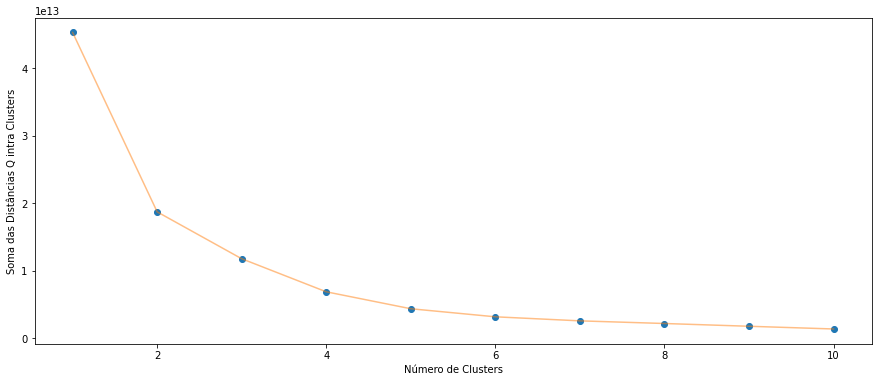

In [81]:
# Selecionando o número de clusters através do método Elbow (Soma das distâncias quadráticas intra clusters):
X6 = df_clusterizacao5[['ticket_medio_cotas_resgate' , 'saldo_conta']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(X6)
    inertia.append(algorithm.inertia_)
    
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

Conforme o número de clusters aumenta a soma das distâncias quadráticas intra clusters diminui, quando a diferença entre a distância é quase insignificante temos o valor ótimo de k , no nosso exemplo esse valor seria igual a 2.

In [82]:
# Inicializando e Computando o KMeans com o valor de 3 clusters:
algorithm = (KMeans(n_clusters = 2))
algorithm.fit(X6)

# Saída:

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(n_clusters=4, n_jobs=None, precompute_distances='auto')

In [83]:
df_clusterizacao5["cluster5"] = algorithm.labels_
df_clusterizacao5.head(50)

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1,cluster2,cluster3,cluster4,cluster5
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0,0,0,0,0
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0,0,0,0,0
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0,0,0,0,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0,0,0,0,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2,1,1,1,0
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000e+00,0,0,0,0,0,0
6,254603,1,0,2.061346e+04,0.000000e+00,2.061346e+04,1,0,0,0,0,0
7,355803,3,6,1.106646e+06,-5.533231e+05,0.000000e+00,0,2,0,1,1,0
8,387403,1,1,5.059604e+04,-5.059603e+04,0.000000e+00,0,0,0,0,0,0
9,415661,1,1,1.540032e+06,-1.540032e+06,0.000000e+00,0,2,1,1,1,0


In [84]:
df_group = df_clusterizacao5.groupby("cluster5")
df_group.head()

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1,cluster2,cluster3,cluster4,cluster5
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0,0,0,0,0
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0,0,0,0,0
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0,0,0,0,0
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0,0,0,0,0
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2,1,1,1,0
13,417869,6,0,2.048065e+05,0.000000e+00,1.228839e+06,1,1,0,0,1,1
14,418451,8,5,3.919526e+05,-2.791800e+05,1.739721e+06,1,1,0,0,1,1
17,419107,2,0,7.634688e+05,0.000000e+00,1.526938e+06,1,1,0,1,1,1
21,439217,27,0,8.298390e+04,0.000000e+00,2.240565e+06,1,1,0,0,1,1
40,872527,3,0,6.013791e+05,0.000000e+00,1.804137e+06,1,1,0,1,1,1


In [85]:
df_group.describe()

conta                                                    \
           count          mean           std       min         25%   
cluster5                                                             
0         7044.0  6.307199e+07  5.372971e+07   15825.0  12955163.0   
1           17.0  5.150405e+06  4.209934e+06  417869.0    872527.0   

                                               qtd_aplicacoes            ...  \
                 50%          75%          max          count      mean  ...   
cluster5                                                                 ...   
0         13164598.0  120146177.0  120756531.0         7044.0  1.789324  ...   
1          4730839.0    8859999.0   13105147.0           17.0  8.411765  ...   

         cluster3      cluster4                                              
              75%  max    count      mean      std  min  25%  50%  75%  max  
cluster5                                                                     
0             0.0  1.0   7044.0  0.001988  0.04454  0.0  0.0  0.0  0.0  1.0  
1             0.0  1.0     17.0  1.000000  0.00000  1.0  1.0  1.0  1.0  1.0  

[2 rows x 88 columns]

## Cluster 06 com variaveis (qtd_aplicacoes e qtd_resgates)

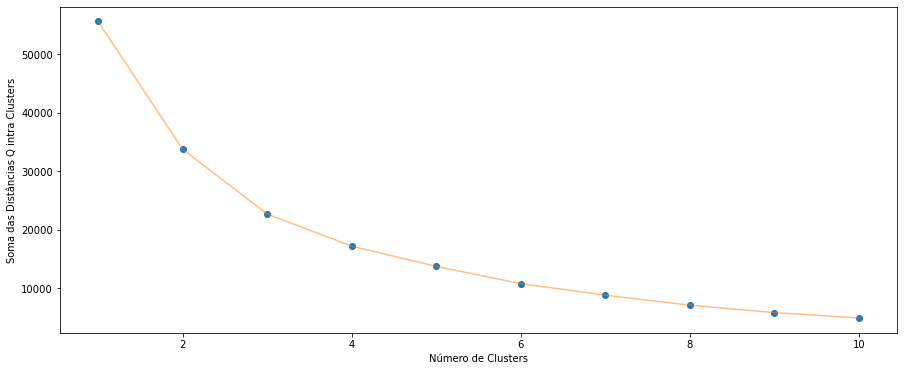

In [86]:
# Selecionando o número de clusters através do método Elbow (Soma das distâncias quadráticas intra clusters):
X7 = df_clusterizacao5[['qtd_aplicacoes', 'qtd_resgates']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(X7)
    inertia.append(algorithm.inertia_)
    
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

Conforme o número de clusters aumenta a soma das distâncias quadráticas intra clusters diminui, quando a diferença entre a distância é quase insignificante temos o valor ótimo de k , no nosso exemplo esse valor seria igual a 3.

In [87]:
# Inicializando e Computando o KMeans com o valor de 3 clusters:
algorithm = (KMeans(n_clusters = 3))
algorithm.fit(X7)

# Saída:

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(n_clusters=4, n_jobs=None, precompute_distances='auto')

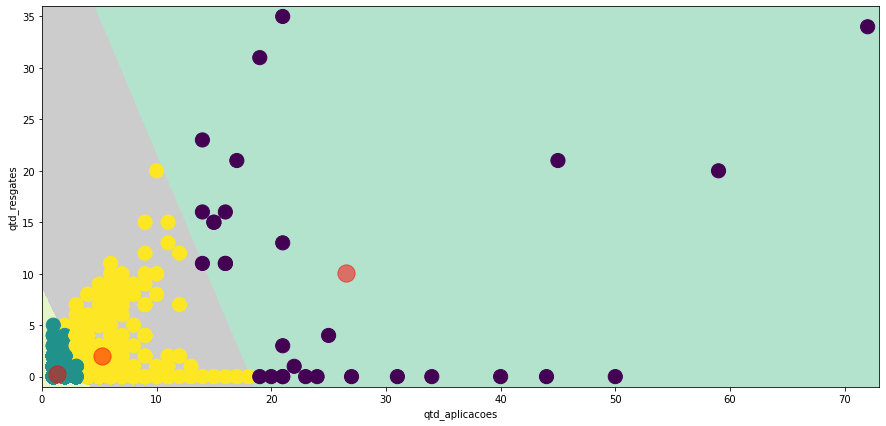

In [88]:
# Visualizando os grupos criados e seus centroides:
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X7[:, 0].min() - 1, X7[:, 0].max() + 1
y_min, y_max = X7[:, 1].min() - 1, X7[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter( x = 'qtd_aplicacoes' ,y = 'qtd_resgates' , data = df_clusterizacao5 , c = labels2 , s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('qtd_resgates') , plt.xlabel('qtd_aplicacoes')
plt.show()

In [89]:
df_clusterizacao5["cluster6"] = algorithm.labels_
df_clusterizacao5.head(50)

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0,0,0,0,0,1
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0,0,0,0,0,1
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0,0,0,0,0,1
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0,0,0,0,0,2
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2,1,1,1,0,1
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000e+00,0,0,0,0,0,0,1
6,254603,1,0,2.061346e+04,0.000000e+00,2.061346e+04,1,0,0,0,0,0,1
7,355803,3,6,1.106646e+06,-5.533231e+05,0.000000e+00,0,2,0,1,1,0,2
8,387403,1,1,5.059604e+04,-5.059603e+04,0.000000e+00,0,0,0,0,0,0,1
9,415661,1,1,1.540032e+06,-1.540032e+06,0.000000e+00,0,2,1,1,1,0,1


In [90]:
df_group = df_clusterizacao5.groupby("cluster6")
df_group.head()

,conta,qtd_aplicacoes,qtd_resgates,ticket_medio_cotas_aplicacao,ticket_medio_cotas_resgate,saldo_conta,ATIVO_INATIVO,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
0,15825,3,0,9.369605e+03,0.000000e+00,2.810881e+04,1,0,0,0,0,0,1
1,94135,1,0,4.081277e+04,0.000000e+00,4.081277e+04,1,0,0,0,0,0,1
2,110277,1,1,1.009961e+05,-1.009961e+05,0.000000e+00,0,0,0,0,0,0,1
3,247291,4,4,2.495116e+05,-2.495116e+05,0.000000e+00,0,0,0,0,0,0,2
4,247303,1,1,1.737055e+06,-1.737055e+06,0.000000e+00,0,2,1,1,1,0,1
5,247741,1,1,7.523638e+04,-7.523638e+04,0.000000e+00,0,0,0,0,0,0,1
7,355803,3,6,1.106646e+06,-5.533231e+05,0.000000e+00,0,2,0,1,1,0,2
10,417687,9,4,6.334104e+04,-3.677227e+04,4.229803e+05,1,0,0,0,0,0,2
12,417849,7,9,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,2
13,417869,6,0,2.048065e+05,0.000000e+00,1.228839e+06,1,1,0,0,1,1,2


In [91]:
df_group.describe()

conta                                                    \
           count          mean           std       min         25%   
cluster6                                                             
0           30.0  1.889077e+07  2.767110e+07  439217.0  12573637.5   
1         6323.0  6.727849e+07  5.380954e+07   15825.0  12981034.0   
2          708.0  2.598594e+07  3.603532e+07  247291.0  12735306.5   

                                                qtd_aplicacoes             \
                  50%          75%          max          count       mean   
cluster6                                                                    
0          12661441.0   12852806.5  120073565.0           30.0  26.533333   
1         120001365.0  120173284.0  120756531.0         6323.0   1.304602   
2          12865672.0   13081222.0  120595999.0          708.0   5.228814   

          ... cluster4      cluster5                                          \
          ...      75%  max    count      mean       std  min  25%  50%  75%   
cluster6  ...                                                                  
0         ...      0.0  1.0     30.0  0.100000  0.305129  0.0  0.0  0.0  0.0   
1         ...      0.0  1.0   6323.0  0.001107  0.033257  0.0  0.0  0.0  0.0   
2         ...      0.0  1.0    708.0  0.009887  0.099011  0.0  0.0  0.0  0.0   

               
          max  
cluster6       
0         1.0  
1         1.0  
2         1.0  

[3 rows x 96 columns]

In [92]:
#https://www.debit.com.br/tabelas/indicadores-economicos-diarios.php?indexador=12&imes=01&iano=2015&fmes=07&fano=2021
dolar = pd.read_excel('dolar.xlsx')
dolar = pd.DataFrame(dolar)
dolar.columns = ['data','dolar']
ipca = pd.read_excel('IPCA.xlsx')
ipca = pd.DataFrame(ipca)
ipca.columns = ['mes_ano','ipca','IGPM','IBOVESPA_REAL','IBOVESPA_dolar']
ipca['mes_ano'] = pd.to_datetime(ipca['mes_ano'])

df10 = df10.merge(dolar, how='left', on='data')
df10['mes_ano'] = pd.to_datetime(df10['mes_ano'])
df10 = df10.merge(ipca, how='left', on='mes_ano')

In [96]:
df10

,#,data,conta,operação,cota,quantidade,financeiro,grupo,Flag_aplicacao,Flag_resgate,Year,Month,mes_ano,dolar,ipca,IGPM,IBOVESPA_REAL,IBOVESPA_dolar
0,1,2015-03-23,419103,aplicação,1.000000,2.000000e+05,200000.0,Proprietário,1,0,2015,3,2015-03-01,3.1793,1.32,0.98,1.924068e+12,5.997718e+11
1,2,2015-03-23,419107,aplicação,1.000000,1.200000e+06,1200000.0,Proprietário,1,0,2015,3,2015-03-01,3.1793,1.32,0.98,1.924068e+12,5.997718e+11
2,3,2015-03-23,418451,aplicação,1.000000,5.000000e+05,500000.0,Proprietário,1,0,2015,3,2015-03-01,3.1793,1.32,0.98,1.924068e+12,5.997718e+11
3,4,2015-03-23,418453,aplicação,1.000000,5.000000e+05,500000.0,Proprietário,1,0,2015,3,2015-03-01,3.1793,1.32,0.98,1.924068e+12,5.997718e+11
4,5,2015-03-24,387403,aplicação,0.988220,5.059604e+04,50000.0,Pessoa Física,1,0,2015,3,2015-03-01,3.1304,1.32,0.98,1.924068e+12,5.997718e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16101,16102,2021-06-30,10638925,aplicação,4.746005,7.585328e+04,360000.0,Corporativo,1,0,2021,6,2021-06-01,5.0016,0.53,0.60,0.000000e+00,0.000000e+00
16102,16103,2021-06-30,12862919,aplicação,4.746005,1.053518e+03,5000.0,Plataforma,1,0,2021,6,2021-06-01,5.0016,0.53,0.60,0.000000e+00,0.000000e+00
16103,16104,2021-06-30,120755489,aplicação,4.746005,6.953217e+03,33000.0,Plataforma,1,0,2021,6,2021-06-01,5.0016,0.53,0.60,0.000000e+00,0.000000e+00
16104,16105,2021-06-30,120750393,aplicação,4.746005,1.053518e+03,5000.0,Plataforma,1,0,2021,6,2021-06-01,5.0016,0.53,0.60,0.000000e+00,0.000000e+00


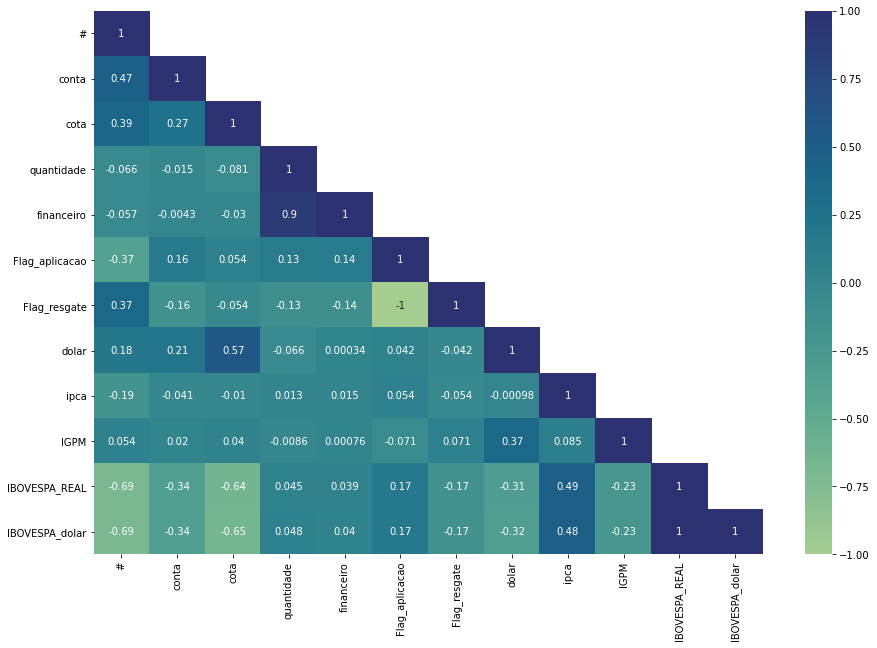

In [93]:
plt.figure(figsize=(15,10))
mask = np.triu(df10.corr(),1)
sns.heatmap(df10.corr(), annot=True,mask=mask, cmap="crest")
plt.show()

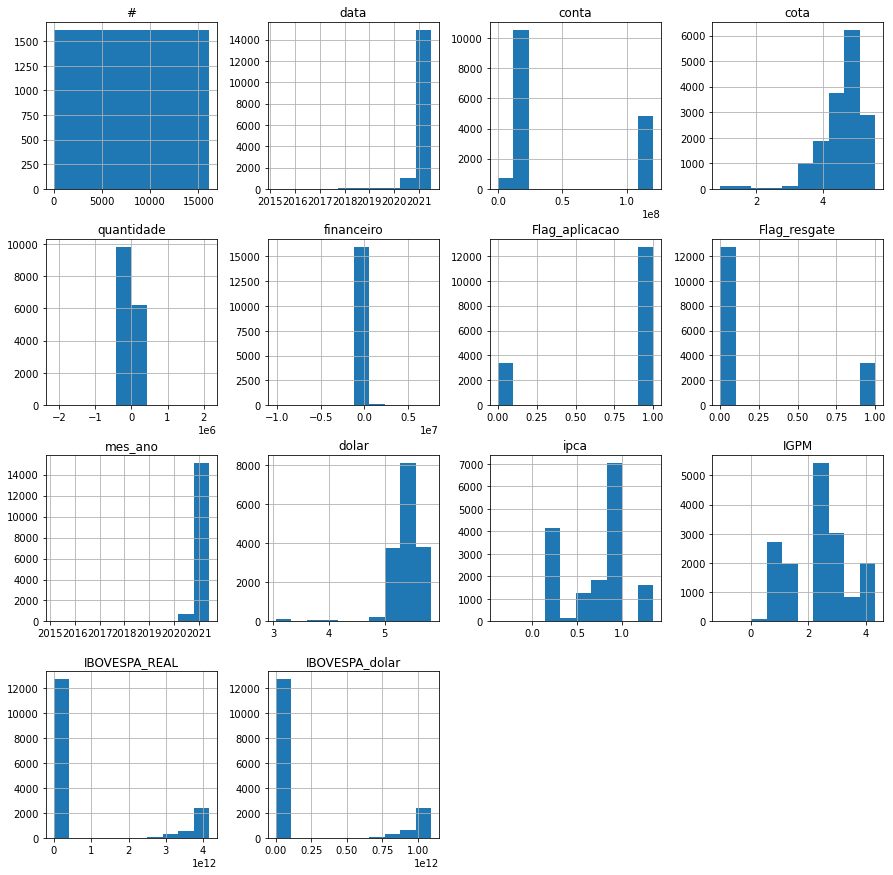

In [94]:
df10.hist(figsize=(15,15))
plt.show()

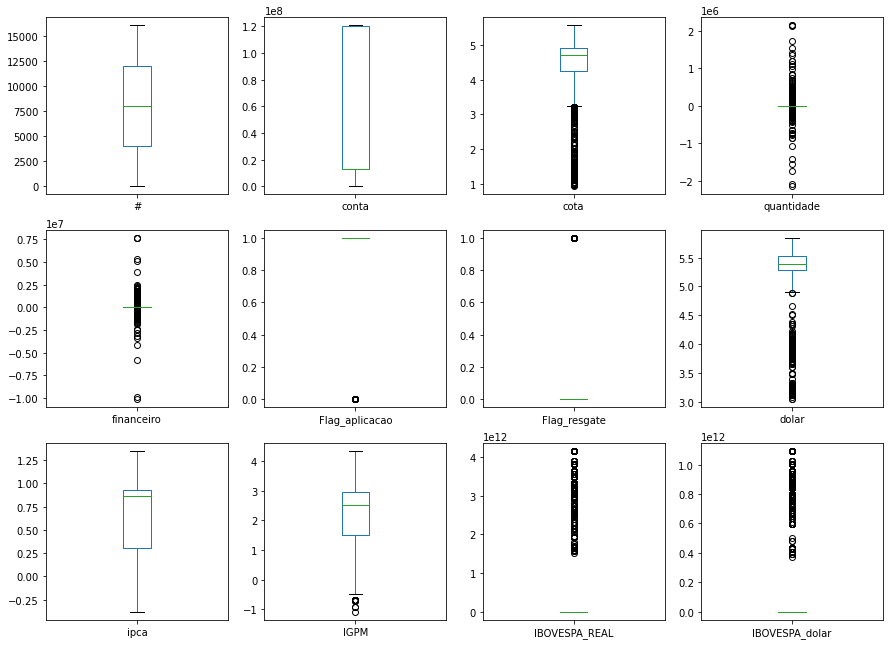

In [95]:
df10.plot(kind="box", subplots = True,layout = (4,4),figsize=(15,15))
plt.show()